# load

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio
import os
import pickle
%load_ext autoreload
%autoreload 2

In [2]:
local_flag = False
if local_flag:
    repo_dir = r'D:\repo\inter_data\inter'.replace("\\", "/") # under env dimred
else:
    repo_dir = r'C:\Users\ll357\Documents\inter'.replace("\\", "/")
os.chdir(repo_dir)
from src import adp

dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\V1_i1375_230103_cellpose/'
stim_id, trace_by_trial = adp.load_trace_trial_data(os.path.join(dir_data), vis_filter=False)

trace_cell_avg: (197,).         trace_stim_avg list len: 6.         trace_stim_avg[0].shape: (197,)


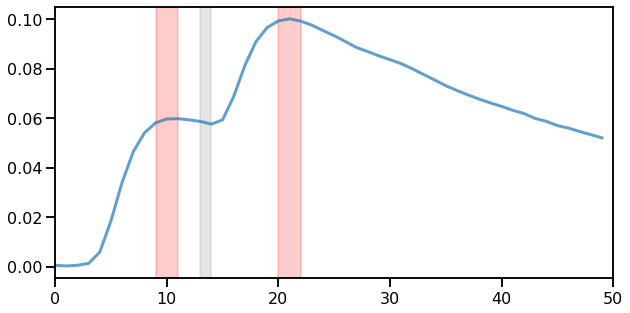

In [4]:
trace_avg_cell, trace_cell_sem, trace_stim_avg = adp.calc_trace_stim(trace_by_trial, stim_id)

fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(trace_avg_cell[:50], alpha=0.7, linewidth=3)
ax.axvspan(9,11, alpha=0.2, color='red')
ax.axvspan(13,14, alpha=0.2, color='gray')
ax.axvspan(20,22, alpha=0.2, color='red')
plt.xlim(0, 50);

In [5]:
# get resp_ad and resp_tg [cell x trial]

base1 = trace_by_trial[:,:,0:2+1].mean(axis=2) # avg over time window frames
resp_ad = trace_by_trial[:,:,9:11+1].mean(axis=2)
resp_ad = resp_ad - base1

base2 = trace_by_trial[:,:,13:14+1].mean(axis=2)
resp_tg = trace_by_trial[:,:,20:22+1].mean(axis=2)
resp_tg = resp_tg - base2

resp_ad.shape, resp_tg.shape

((91, 1012), (91, 1012))

# tidy data

In [6]:
R1_dfof = resp_ad.flatten() # cell x trial, row major flatten
R2_dfof = resp_tg.flatten()
dfof = np.hstack((R1_dfof, R2_dfof))

ncell = resp_ad.shape[0]
ntrial = resp_ad.shape[1]
cell_id = np.repeat(np.arange(ncell), ntrial)
cell_id = np.hstack((cell_id, cell_id)) # stack two copies for R1 and R2

trial_id = np.tile(np.arange(ntrial), ncell)
trial_id = np.hstack((trial_id, trial_id))

stim_id_col = np.tile(stim_id[0], ncell)
stim_id_col = np.hstack((stim_id_col, stim_id_col))
stim_id_col = stim_id_col - 1 # stim id adjusted to 0-based index

len_df = ncell * ntrial * 2 # 2 for (R1, R2)
resp_id = ['R1'] * (len_df//2) + ['R2'] * (len_df//2) # first half is flattened resp_ad, second half is flattened resp_tg

# construct dataframe
df_tidy = pd.DataFrame({'dfof': dfof, 'cell_id': cell_id, 'trial_id': trial_id, 'stim_id': stim_id_col, 'resp_id': resp_id})
df_tidy.tail(5)
# TODO: when we need to concat across experiments, can add col for mouse, date, area, session

,dfof,cell_id,trial_id,stim_id,resp_id
184179,0.090027,90,1007,4,R2
184180,-0.002115,90,1008,1,R2
184181,0.044474,90,1009,3,R2
184182,-0.064555,90,1010,1,R2
184183,0.029093,90,1011,0,R2


# trial filter

In [7]:
trial_filter_file = [f for f in os.listdir(dir_data) if f.__contains__('filter_trials_')]

trial_ok = np.array([])
for file in trial_filter_file:
    trial_filter = sio.loadmat(os.path.join(dir_data, file))
    trial_eye_ok = trial_filter['trial_eye_ok']
    trial_eye_ok = np.array([i[0] for i in trial_eye_ok], dtype=bool)
    trial_speed_ok = trial_filter['trial_speed_ok']
    trial_speed_ok = np.array([i[0] for i in trial_speed_ok], dtype=bool)
    trial_ok_sess = trial_eye_ok & trial_speed_ok
    trial_ok_sess = trial_ok_sess[:-1] # remove the last trial, which is not a full trial
    trial_ok = np.append(trial_ok, trial_ok_sess)

trial_ok = np.array(trial_ok, dtype=bool)
assert len(trial_ok) == trace_by_trial.shape[1]
# sum(trial_ok), len(trial_ok)

filter_trial = np.tile(trial_ok, ncell)
filter_trial = np.hstack((filter_trial, filter_trial))
df_tidy['filter_trial'] = filter_trial

# cell x stim filter
using vis_driven.ipynb  
TODO: refactor it into adp.py

In [22]:
df_tidy['filter_cell'] = np.nan
df_tidy['filter_cell_stim'] = np.nan

with open(os.path.join(dir_data, 'vis_driven.pickle'), 'rb') as f:
    filter_file = pickle.load(f)
filter_cell_stim = filter_file['img_driven']
filter_cell = filter_file['vis_driven']

# fill filter_cell_stim into df_tidy: for icell and istim
for icell in np.arange(filter_cell_stim.shape[0]):
    df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell'] = filter_cell[icell][0] # filter_cell is a list of list
    for istim in np.arange(filter_cell_stim.shape[1]):
        df_tidy.loc[(df_tidy['stim_id']==istim) & (df_tidy['cell_id']==icell), 'filter_cell_stim'] = filter_cell_stim[icell, istim]
df_tidy

# df_tidy['filter_cell_stim'] = True
# print('not using filter_cell_stim')

,dfof,cell_id,trial_id,stim_id,resp_id,filter_trial,filter_cell_stim,filter_cell
0,-0.133319,0,0,4,R1,True,False,True
1,0.113303,0,1,2,R1,True,True,True
2,-0.018100,0,2,2,R1,True,True,True
3,-0.032178,0,3,3,R1,True,True,True
4,-0.065120,0,4,2,R1,True,True,True
...,...,...,...,...,...,...,...,...
184179,0.090027,90,1007,4,R2,True,False,True
184180,-0.002115,90,1008,1,R2,True,True,True
184181,0.044474,90,1009,3,R2,True,True,True
184182,-0.064555,90,1010,1,R2,True,True,True


# tidy data filtered 
discarded invalid trial and cell x stim combo

In [25]:
df_filter = df_tidy[df_tidy['filter_trial']]
df_filter.loc[df_filter['filter_cell']==False, :] = np.nan # vis driven filter
# df_filter.loc[df_filter['filter_cell_stim']==False, :] = np.nan # img driven filter

df_filter#.sample(5, random_state=42)
df_filter.stim_id.value_counts() // df_filter.cell_id.nunique() // 2 # 2 is for R1 and R2. each stim repeat 130+ times

C:\Users\ll357\AppData\Local\Temp\2\ipykernel_48096\986700016.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter.loc[df_filter['filter_cell']==False, :] = np.nan # vis driven filter


0.0    154
1.0    154
2.0    143
4.0    142
5.0    142
3.0    131
Name: stim_id, dtype: int64

# adaptation vs SF
## construct filter_pref

In [26]:
df_pref = df_filter.copy()
df_pref['filter_pref'] = False

# for each cell, find the stim with the largest resp
for icell in np.arange(resp_ad.shape[0]):
    df_cell = df_pref[df_pref['cell_id']==icell]
    df_cell = df_cell[df_cell['resp_id']=='R1'] # only use R1
    # df_cell = df_cell[df_cell['filter_cell_stim']==True] # only use img_driven
    df_cell = df_cell[df_cell['filter_trial']==True] # only use trial_ok
    df_cell = df_cell[df_cell['dfof'].notna()] # only use not nan
    if len(df_cell) == 0:
        continue
    df_cell = df_cell.sort_values(by='dfof', ascending=False)
    pref_stim = df_cell.iloc[0]['stim_id']
    df_pref.loc[(df_pref['cell_id']==icell) & (df_pref['stim_id']==pref_stim), 'filter_pref'] = True

df_pref = df_pref[df_pref['filter_pref']] # only retain preferred stim x cell combo
df_pref

,dfof,cell_id,trial_id,stim_id,resp_id,filter_trial,filter_cell_stim,filter_cell,filter_pref
10,0.015105,0.0,10.0,0.0,R1,True,True,True,True
14,-0.034426,0.0,14.0,0.0,R1,True,True,True,True
25,-0.015726,0.0,25.0,0.0,R1,True,True,True,True
30,-0.018084,0.0,30.0,0.0,R1,True,True,True,True
36,0.015564,0.0,36.0,0.0,R1,True,True,True,True
...,...,...,...,...,...,...,...,...,...
184134,-0.002698,90.0,962.0,0.0,R2,True,True,True,True
184140,0.015739,90.0,968.0,0.0,R2,True,True,True,True
184163,0.109854,90.0,991.0,0.0,R2,True,True,True,True
184178,-0.053032,90.0,1006.0,0.0,R2,True,True,True,True


## boot adp for pop

In [27]:
df_pref.stim_id.value_counts().sort_index() // df_pref.cell_id.nunique() // 2 # stim nrep x ncell x 2 (R1, R2)

0.0    56
1.0    24
2.0    34
3.0    22
4.0     8
5.0     1
Name: stim_id, dtype: int64

In [75]:
# output should be of shape: nboot x nstim x ncell
# for each bootstrap, for each stim x cell, randomly select nrep trials

nboot = 100
nrep_selected = 20

adp_boot = []
for iboot in np.arange(nboot):
    R1_agg = (df_pref[(df_pref['resp_id']=='R1')]
                    .groupby(['stim_id', 'cell_id'])['dfof']
                    .apply(lambda x: x.sample(n=nrep_selected, replace=True).sum())
                    .reset_index()['dfof'].values) # for each stim x cell, randomly select nrep trials resp, take sum
    R2_agg = (df_pref[(df_pref['resp_id']=='R2')]
                    .groupby(['stim_id', 'cell_id'])['dfof']
                    .apply(lambda x: x.sample(n=nrep_selected, replace=True).sum())
                    .reset_index()['dfof'].values)
    adp_agg = (R2_agg - R1_agg) / (R1_agg + 1e-7)
    adp_agg[np.abs(adp_agg) > 5] = np.nan # remove outliers
    adp_boot.append(adp_agg)
print('adp hard thresholding')

adp_boot[0].shape, len(adp_boot)

adp hard thresholding


((88,), 100)

In [76]:
# preferred stim x cell combo

df_adp_pref = (df_pref[(df_pref['resp_id']=='R1')]
                .groupby(['stim_id', 'cell_id'])['dfof']
                .apply(lambda x: x.sample(n=nrep_selected, replace=True).sum())
                .reset_index())

adp_boot = np.array(adp_boot)
adp_boot = np.mean(adp_boot, axis=0) # sum over all bootstraps
df_adp_pref['adp_pref'] = adp_boot
df_adp_pref

,stim_id,cell_id,dfof,adp_pref
0,0.0,0.0,0.398244,NaN
1,0.0,2.0,3.855297,-0.042248
2,0.0,3.0,0.995485,-0.149294
3,0.0,5.0,1.231995,0.587683
4,0.0,7.0,0.545166,NaN
...,...,...,...,...
83,4.0,19.0,1.947689,-0.167894
84,4.0,31.0,-0.017861,NaN
85,4.0,64.0,4.934840,0.158724
86,4.0,74.0,0.957328,-0.084920


### boxplot across cells
for each SF, take cells that prefer this grating SF. boxplot errorbar is across cells

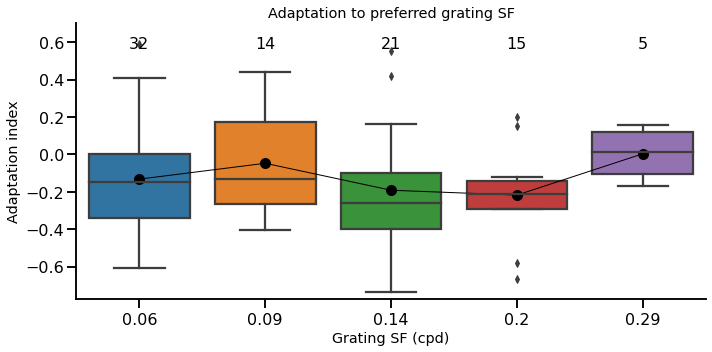

In [79]:
# for each stim_id, plot adp_pref for each cell in a boxplot

fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x='stim_id', y='adp_pref', data=df_adp_pref, ax=ax)
ax.plot(df_adp_pref.groupby('stim_id')['adp_pref'].mean().values, 'k', marker='o', markersize=10, linewidth=1)

# add text at each xtick
ncell_SF = df_adp_pref.groupby('stim_id')['cell_id'].nunique().values
for i, stim_id in enumerate(ncell_SF[:-1]): # last ncell=1, no need to plot
    stim_id = int(stim_id)
    ax.text(i, 0.59, stim_id, ha='center', va='center', fontsize=16)

ax.set_xlabel('Grating SF (cpd)')
cpd_array = np.round(np.geomspace(0.03, 0.9, num=10), 2)[2:-2] # remove low freq and high freq
ax.set_xticklabels(cpd_array)
ax.set_ylabel('Adaptation index')
# set ylim upper bound to 0.7, auto adjust lower bound
ax.set_ylim([np.nanmin(df_adp_pref['adp_pref'].values * 1.05), 0.7])
ax.set_title('Adaptation to preferred grating SF');

# turn off upper and right spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.tight_layout()